In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9161992050480043468
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 9944834636919094617
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:89:00.0, compute capability: 3.7"
]


In [2]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

In [3]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [4]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [5]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [6]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [7]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [8]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [9]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [10]:
with open('sniip_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [11]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

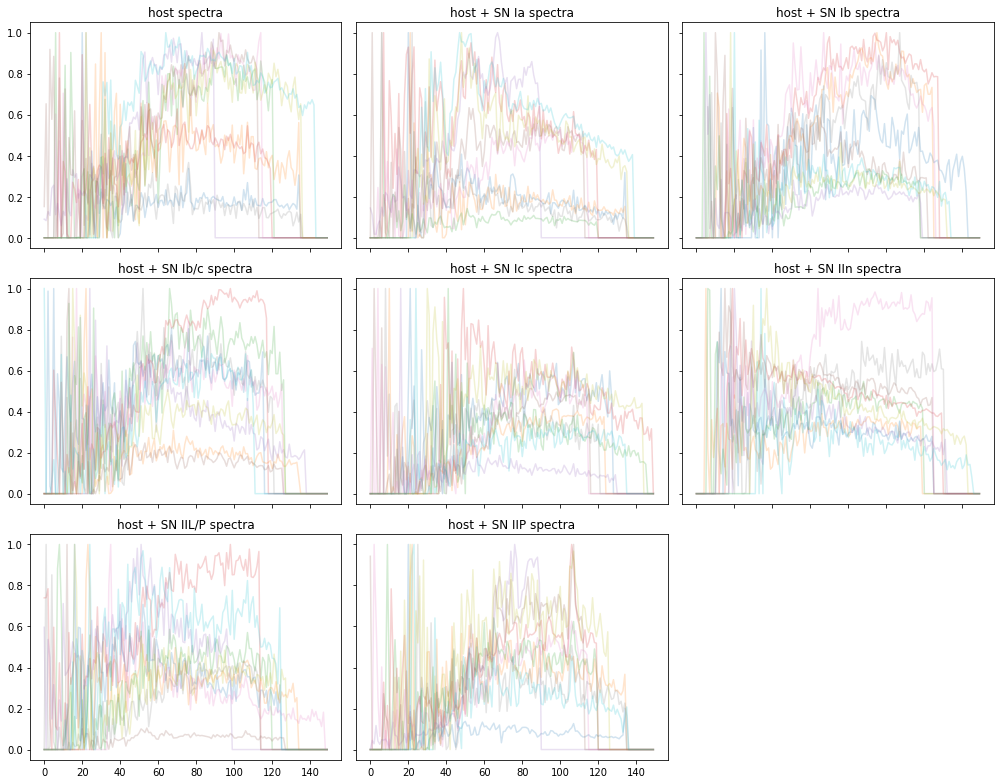

In [12]:
# PLOT
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,50,5):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ib/c spectra')
axes[4].set_title('host + SN Ic spectra')
axes[5].set_title('host + SN IIn spectra')
axes[6].set_title('host + SN IIL/P spectra')
axes[7].set_title('host + SN IIP spectra')

axes[8].axis('off')

fig.tight_layout()


x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [13]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM

In [14]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Accuracy

In [15]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 16s 267us/sample - loss: 2.5753 - acc: 0.4358 - val_loss: 2.0463 - val_acc: 0.5606
Epoch 2/50
58492/58492 [==============================] - 9s 147us/sample - loss: 1.8323 - acc: 0.5910 - val_loss: 1.6613 - val_acc: 0.6200
Epoch 3/50
58492/58492 [==============================] - 9s 147us/sample - loss: 1.5484 - acc: 0.6331 - val_loss: 1.4645 - val_acc: 0.6459
Epoch 4/50
58492/58492 [==============================] - 9s 147us/sample - loss: 1.3844 - acc: 0.6556 - val_loss: 1.3598 - val_acc: 0.6504
Epoch 5/50
58492/58492 [==============================] - 9s 147us/sample - loss: 1.2764 - acc: 0.6714 - val_loss: 1.2643 - val_acc: 0.6672
Epoch 6/50
58492/58492 [==============================] - 9s 147us/sample - loss: 1.2009 - acc: 0.6823 - val_loss: 1.2130 - val_acc: 0.6751
Epoch 7/50
58492/58492 [==============================] - 9s 147us/sample - loss: 1.1482 - acc: 0.6938 - val_

In [16]:
y_pred = model.predict(x_test)

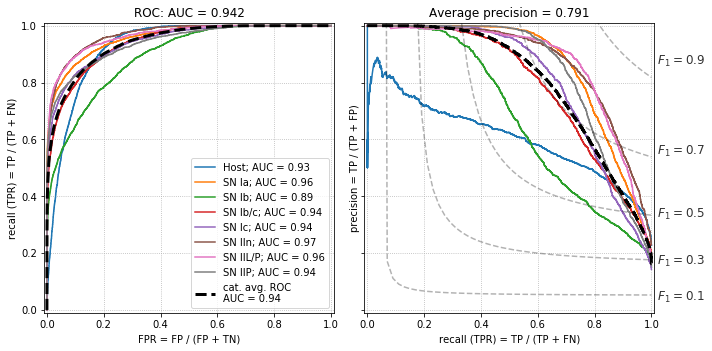

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

In [18]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [19]:
np.arange(cm.shape[1])

array([0, 1, 2, 3, 4, 5, 6, 7])

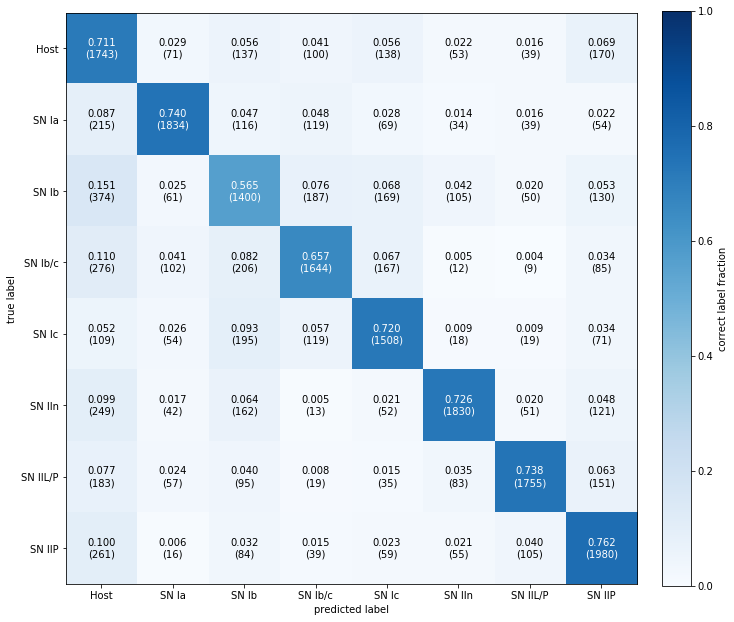

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# AUC + Acc

In [21]:
AUC = tf.keras.metrics.AUC(curve='PR')

In [22]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[AUC,'accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

W0806 14:05:03.783504 47844378055552 deprecation.py:323] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:1792: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 10s 172us/sample - loss: 2.5871 - auc: 0.4894 - acc: 0.4365 - val_loss: 2.0630 - val_auc: 0.6295 - val_acc: 0.5590
Epoch 2/30
58492/58492 [==============================] - 9s 152us/sample - loss: 1.8431 - auc: 0.6711 - acc: 0.5894 - val_loss: 1.6657 - val_auc: 0.7058 - val_acc: 0.6177
Epoch 3/30
58492/58492 [==============================] - 9s 152us/sample - loss: 1.5533 - auc: 0.7230 - acc: 0.6343 - val_loss: 1.4832 - val_auc: 0.7272 - val_acc: 0.6336
Epoch 4/30
58492/58492 [==============================] - 9s 152us/sample - loss: 1.3852 - auc: 0.7501 - acc: 0.6571 - val_loss: 1.3530 - val_auc: 0.7492 - val_acc: 0.6528
Epoch 5/30
58492/58492 [==============================] - 9s 153us/sample - loss: 1.2797 - auc: 0.7674 - acc: 0.6715 - val_loss: 1.2669 - val_auc: 0.7633 - val_acc: 0.6669
Epoch 6/30
58492/58492 [==============================] - 9s 156us/sample - loss: 1.2067 

In [23]:
y_pred = model.predict(x_test)

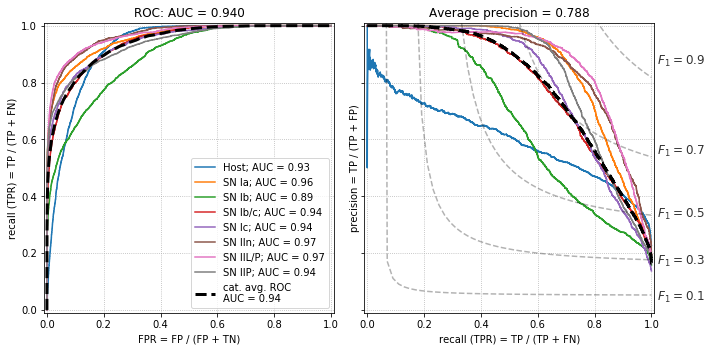

In [24]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

In [25]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

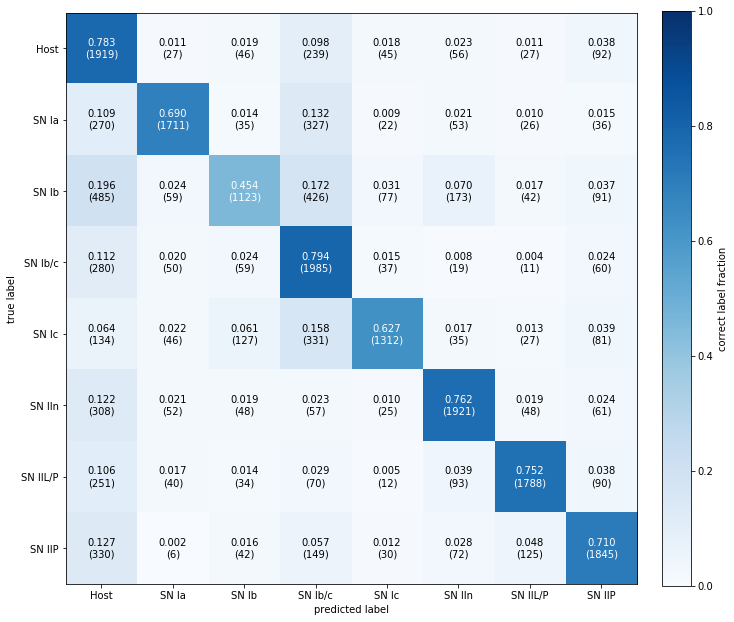

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# AUC

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 10s 173us/sample - loss: 2.5991 - auc: 0.4814 - val_loss: 2.0693 - val_auc: 0.6320
Epoch 2/30
58492/58492 [==============================] - 9s 160us/sample - loss: 1.8613 - auc: 0.6653 - val_loss: 1.6793 - val_auc: 0.7031
Epoch 3/30
58492/58492 [==============================] - 9s 160us/sample - loss: 1.5701 - auc: 0.7179 - val_loss: 1.4990 - val_auc: 0.7242
Epoch 4/30
58492/58492 [==============================] - 9s 160us/sample - loss: 1.4014 - auc: 0.7453 - val_loss: 1.3727 - val_auc: 0.7414
Epoch 5/30
58492/58492 [==============================] - 9s 160us/sample - loss: 1.2909 - auc: 0.7637 - val_loss: 1.2757 - val_auc: 0.7601
Epoch 6/30
58492/58492 [==============================] - 9s 160us/sample - loss: 1.2140 - auc: 0.7767 - val_loss: 1.2126 - val_auc: 0.7718
Epoch 7/30
58492/58492 [==============================] - 9s 159us/sample - loss: 1.1607 - auc: 0.7860 - val_

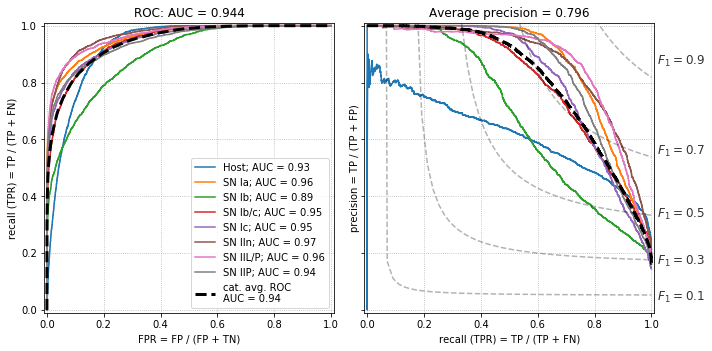

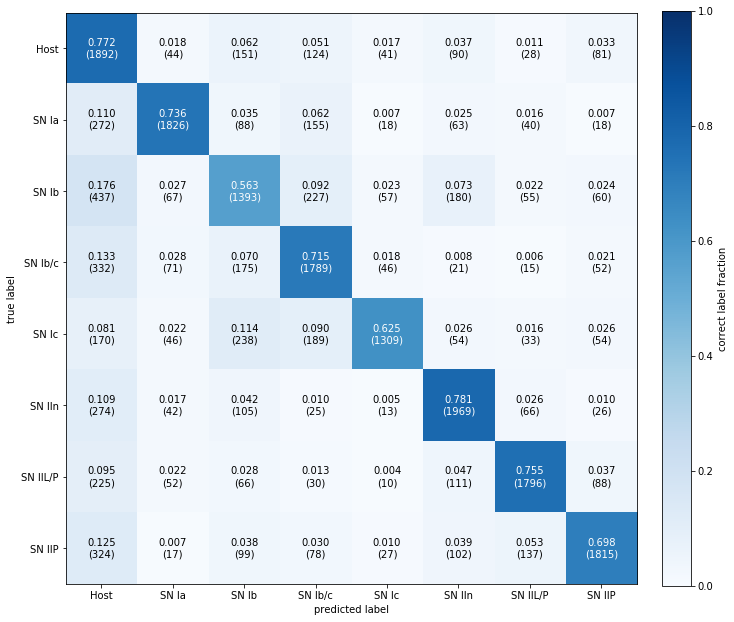

In [27]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[AUC])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# Precision

In [28]:
precision = tf.keras.metrics.Precision()

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 10s 168us/sample - loss: 2.5772 - precision: 0.7755 - val_loss: 2.0621 - val_precision: 0.8085
Epoch 2/30
58492/58492 [==============================] - 9s 153us/sample - loss: 1.8499 - precision: 0.8196 - val_loss: 1.6842 - val_precision: 0.8483
Epoch 3/30
58492/58492 [==============================] - 9s 155us/sample - loss: 1.5592 - precision: 0.8337 - val_loss: 1.4670 - val_precision: 0.8439
Epoch 4/30
58492/58492 [==============================] - 9s 153us/sample - loss: 1.3922 - precision: 0.8393 - val_loss: 1.3599 - val_precision: 0.8391
Epoch 5/30
58492/58492 [==============================] - 9s 153us/sample - loss: 1.2819 - precision: 0.8475 - val_loss: 1.2643 - val_precision: 0.8397
Epoch 6/30
58492/58492 [==============================] - 9s 154us/sample - loss: 1.2106 - precision: 0.8487 - val_loss: 1.2112 - val_precision: 0.8497
Epoch 7/30
58492/58492 [=============

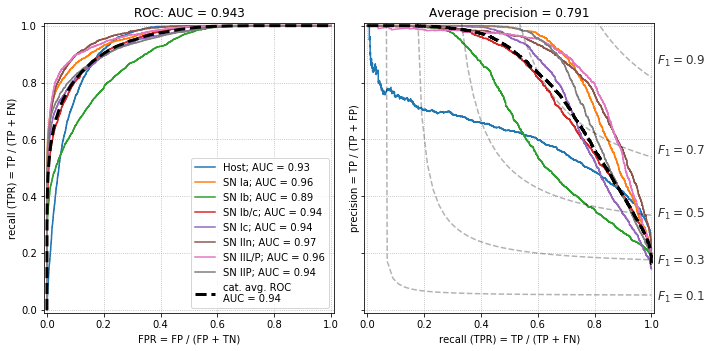

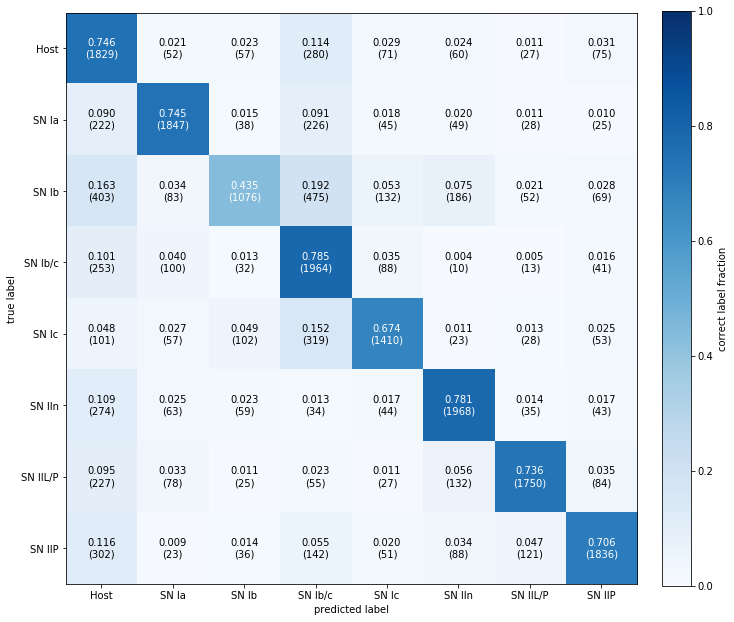

In [29]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[precision])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# Precision + Accuracy

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 10s 173us/sample - loss: 2.6023 - precision: 0.7766 - acc: 0.4363 - val_loss: 2.1238 - val_precision: 0.7911 - val_acc: 0.5350
Epoch 2/30
58492/58492 [==============================] - 9s 157us/sample - loss: 1.8622 - precision: 0.8190 - acc: 0.5868 - val_loss: 1.7013 - val_precision: 0.8254 - val_acc: 0.6136
Epoch 3/30
58492/58492 [==============================] - 9s 157us/sample - loss: 1.5722 - precision: 0.8320 - acc: 0.6276 - val_loss: 1.4800 - val_precision: 0.8508 - val_acc: 0.6466
Epoch 4/30
58492/58492 [==============================] - 9s 157us/sample - loss: 1.4028 - precision: 0.8394 - acc: 0.6521 - val_loss: 1.3739 - val_precision: 0.8317 - val_acc: 0.6490
Epoch 5/30
58492/58492 [==============================] - 9s 157us/sample - loss: 1.2933 - precision: 0.8422 - acc: 0.6684 - val_loss: 1.2705 - val_precision: 0.8498 - val_acc: 0.6695
Epoch 6/30
58492/58492 [=====

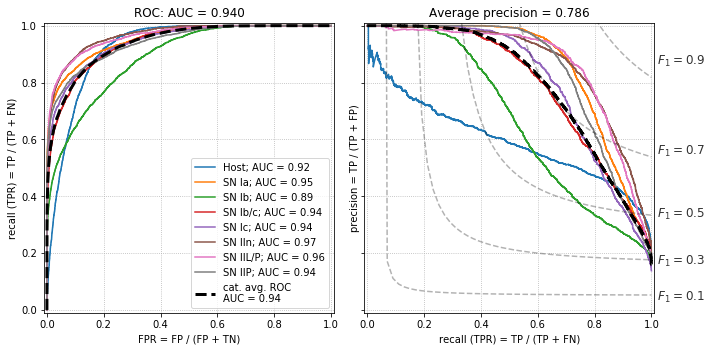

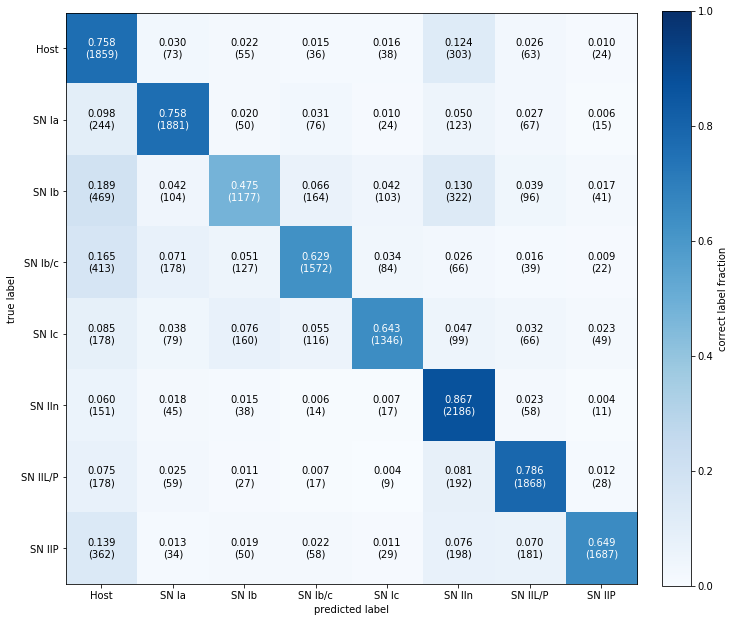

In [30]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=[precision,'accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# Cross and Binary accuracy

In [33]:
# Accuracy

def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['binary_accuracy','categorical_accuracy'])
    
    return model

model = network((nbins, 1),ncat=y.shape[1])

In [34]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 10s 178us/sample - loss: 0.8284 - binary_accuracy: 0.8937 - categorical_accuracy: 0.4377 - val_loss: 0.4604 - val_binary_accuracy: 0.9067 - val_categorical_accuracy: 0.5519
Epoch 2/50
58492/58492 [==============================] - 9s 159us/sample - loss: 0.3719 - binary_accuracy: 0.9135 - categorical_accuracy: 0.5880 - val_loss: 0.3223 - val_binary_accuracy: 0.9165 - val_categorical_accuracy: 0.6006
Epoch 3/50
58492/58492 [==============================] - 9s 159us/sample - loss: 0.2954 - binary_accuracy: 0.9199 - categorical_accuracy: 0.6267 - val_loss: 0.2788 - val_binary_accuracy: 0.9214 - val_categorical_accuracy: 0.6336
Epoch 4/50
58492/58492 [==============================] - 9s 159us/sample - loss: 0.2675 - binary_accuracy: 0.9235 - categorical_accuracy: 0.6442 - val_loss: 0.2608 - val_binary_accuracy: 0.9243 - val_categorical_accuracy: 0.6473
Epoch 5/50
58492/58492 [=====

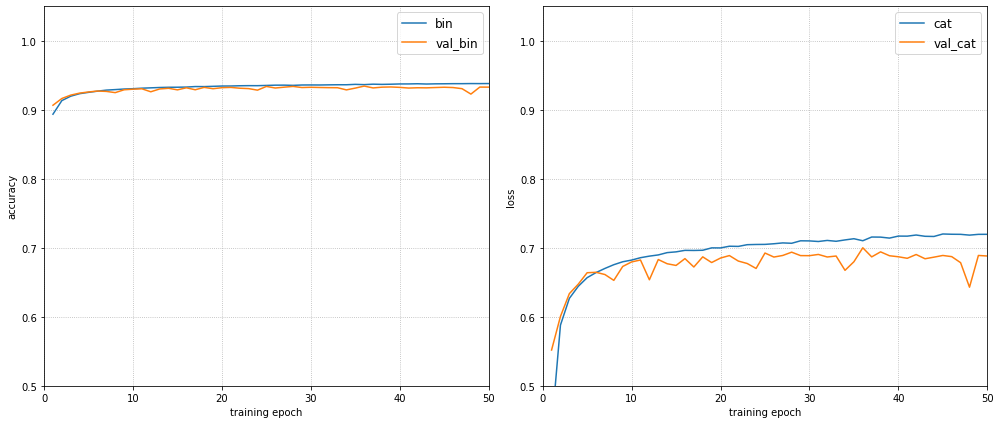

In [35]:
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['binary_accuracy'], label='bin')
ax.plot(epochs, hist.history['val_binary_accuracy'], label='val_bin')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['categorical_accuracy'], label='cat')
ax.plot(epochs, hist.history['val_categorical_accuracy'], label='val_cat')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
fig.tight_layout();